# Machine Learning - Classification

This module, we'll talk about another class of problems we can solve with machine learning. Classification is a subcategory of supervised learning where the goal is to predict the categorical class labels of new instances based on past observations.

Generally, there are 2 main types of classification problems:
- Binary: classifying  into 2 classes. (i.e., Spam and not-spam)
- Multi-class classification: classifying into multiple classes. (i.e., images of handwritten character recognition)

in it's simplest formats, the objective is to find a line or a plane that segregates the data points into different classes.
![simple classification](./assets/simple-classification.png)

In [1]:
# in this cell, we'll import all the libraries and packages we'll need in this tutorial.

# Python ≥3.10 is required
import sys
assert sys.version_info >= (3, 10)

# Common imports
import numpy as np
import pandas as pd
import pandas_profiling
import os

# Scikit Learn imports
from sklearn.preprocessing import (
  PolynomialFeatures,
  OneHotEncoder,
  OrdinalEncoder,
  StandardScaler
)
from sklearn.impute import (
  SimpleImputer
)
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (
  StratifiedShuffleSplit,
  train_test_split
)
from sklearn.compose import ColumnTransformer


# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
plt.style.use("bmh")

# to make this notebook's output stable across runs
np.random.seed(42)

## Titanic Survival
In this tutorial we'll use the titanic dataset from [Encyclopedia Titanica](https://www.encyclopedia-titanica.org/). We will use to train a model that classifies passengers based on whether or not they've survived. The objective would be to develop a model that would predict survival based on other features and attributes.

We'll start with importing the dataset from `data/titanic.csv`, and printing samples of the data.

In [2]:
titanic = pd.read_csv('data/titanic.csv')
titanic.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.00,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.92,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.00,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.00,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.00,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


We see that we have the following features, this info was provided on the [Encyclopedia Titanica](https://www.encyclopedia-titanica.org/).

| Feature     | Description                                                                                             |
| ----------- | ------------------------------------------------------------------------------------------------------- |
| `pclass`    | Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd). This can be considered as proxy for socio-economic status. |
| `survived`  | Survival (0 = No; 1 = Yes)                                                                              |
| `name`      | Name                                                                                                    |
| `sex`       | Sex                                                                                                     |
| `age`       | Age                                                                                                     |
| `sibsp`     | Number of Siblings/Spouses Aboard                                                                       |
| `parch`     | Number of Parents/Children Aboard                                                                       |
| `ticket`    | Ticket Number                                                                                           |
| `fare`      | Passenger Fare                                                                                          |
| `cabin`     | Cabin                                                                                                   |
| `embarked`  | Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)                                    |
| `boat`      | Lifeboat (if survived)                                                                                  |
| `body`      | Body number (if did not survive and body was recovered)                                                 |
| `home.dest` | Home/Destination                                                                                        |

## Prepare - Some EDA
Let's do some exploratory data analysis to get a better understanding of the data. 

In [3]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pclass     1309 non-null   int64  
 1   survived   1309 non-null   int64  
 2   name       1309 non-null   object 
 3   sex        1309 non-null   object 
 4   age        1046 non-null   float64
 5   sibsp      1309 non-null   int64  
 6   parch      1309 non-null   int64  
 7   ticket     1309 non-null   object 
 8   fare       1308 non-null   float64
 9   cabin      295 non-null    object 
 10  embarked   1307 non-null   object 
 11  boat       486 non-null    object 
 12  body       121 non-null    float64
 13  home.dest  745 non-null    object 
dtypes: float64(3), int64(4), object(7)
memory usage: 143.3+ KB


let's visualize the histogram of the data to see the distribution of the data.

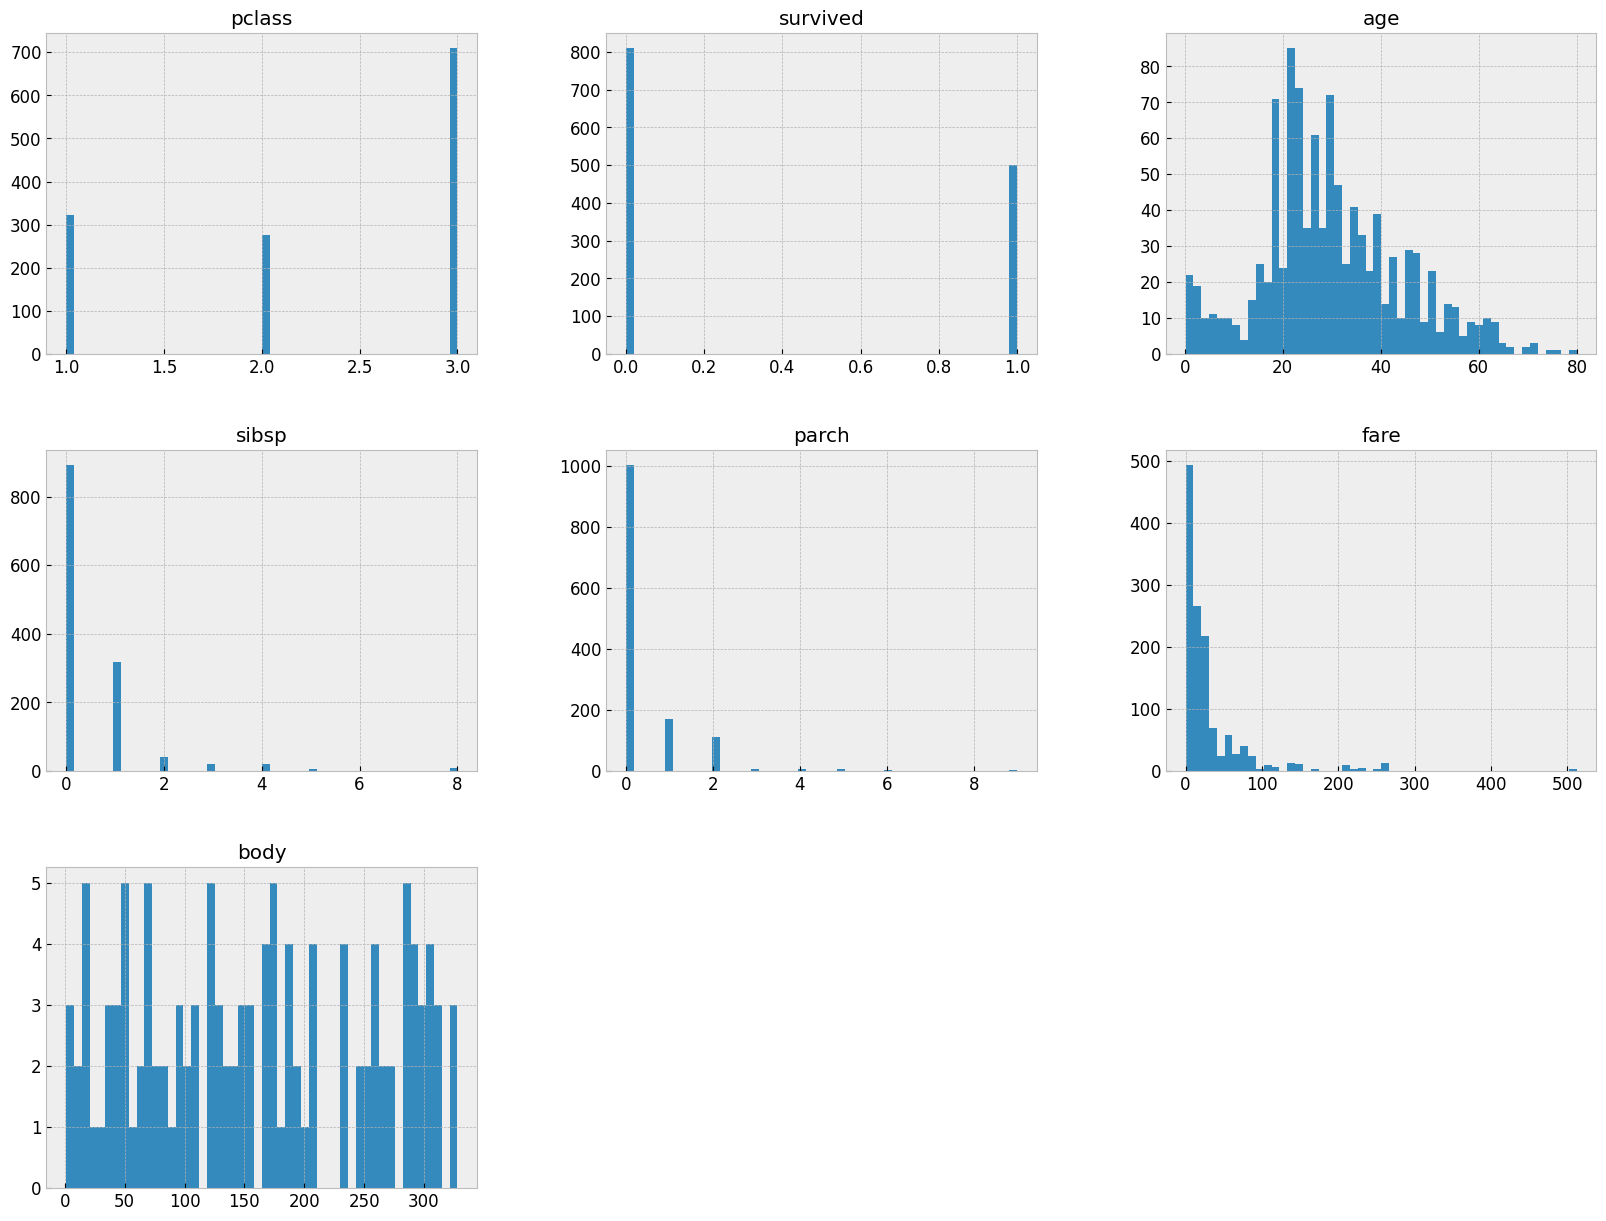

In [4]:
# REMEMBER: number of bins indicate the number if intervals we want to divide our data into
titanic.hist(bins=50, figsize=(20,15))
plt.show()

> 🦉 **Note**: Take a moment and try to make some observations based on the above before you continue reading the below.

We can observer the following:

- Most of the passengers were in the 3rd class.
- `survived` is the target variable, and we can see that most of the passengers did not survive.
- Majority of passengers were traveling alone (no siblings or spouses, no parents or children).
- There's a lot of missing data in the `cabin`, and `age` columns.
- `pclass`, `sex`, `embarked` are categorical variables.

| Column     | Type                                          | notes                                                                                                                                   |
| ---------- | --------------------------------------------- | --------------------------------------------------------------------------------------------------------------------------------------- |
| pclass     | categorical - ordinal                         |                                                                                                                                         |
| name       | string - would this be valuable to our model? |                                                                                                                                         |
| sex        | categorical - nominal                         |                                                                                                                                         |
| age        | numerical - continuous                        | the reason why it's not discrete, is that we see the column type set to float64, and some of the values are 0.92 (less than a year old) |
| sibsp      | numerical - discrete                          |                                                                                                                                         |
| parch      | numerical - discrete                          |                                                                                                                                         |
| ticket     | string - would this be valuable to our model? |                                                                                                                                         |
| fare       | numerical - continuous                        |                                                                                                                                         |
| cabin      | _(Quiz Question)_                             |                                                                                                                                         |
| embarked   | Categorical - could be ordinal or nominal     | Do we think people who boarded first, had better chances of survival?                                                                   |
| boat       | string                                        | boat identifier                                                                                                                         |
| body       | numerical (or string)                         | body ID                                                                                                                                 |
| home. dest |                                               |                                                                                                                                         |
| survived   | category _(ordinal, or nominal?)_             |                                                                                                                                         |

- we also realize that both `boat` and `body` are what we call **Leaky Features**. These are features that kind of gives the answer about the future. Having a `body` number, means they didn't survive. These are features that are not available at the time of prediction, and therefore should not be used in the model. We'll drop these features later on.


**how about missing values?**

In [5]:
titanic.isnull().sum()

pclass          0
survived        0
name            0
sex             0
age           263
sibsp           0
parch           0
ticket          0
fare            1
cabin        1014
embarked        2
boat          823
body         1188
home.dest     564
dtype: int64

We will need to impute the missing values in the Age column.

**BUT** we shouldn't do any of that until the data is split into training and test sets. We don't want to introduce any bias into the data.

Let me show another interesting library called `pandas_profiling`. This library will generate a report of the data, and it's very useful for exploratory data analysis.

if you don't already have it installed, you can install it with `pipenv install pandas-profiling ipywidgets`.

> 🦉 **Note**: The report looks like a webpage embedded in the notebook, if you're using Jupyter Lab or VSCode. It may look a bit different if you're viewing this directly on GitHub.

In [6]:
# pandas_profiling.ProfileReport(titanic, title='Pandas Profiling Report')

The generated report is able, to a high degree of correctness, to detect the data types of the columns, and also detect missing values.
It's able to show the distribution of the data, and also the correlation between the features.

Before we proceed any further, and before we start cleaning, the data, dropping columns, or anything else, we need to split the data into training and test sets.

____________________

## Prepare - Data Splitting

- should we stratify or not?
With large datasets, stratified sampling is a good idea. This is because we want to make sure that the training and test sets have the same distribution of the target variable.

in talking with a hypothetical subject-matter expert (SME), they mentioned that when splitting the data, we need:
- all passenger classes needs to be represented in the dataset with the same frequency as they appear in the original dataset.
- They also had a theory that the `embarked` column may have some effect  SME suggested that we should use `embarked` as the stratification feature.

Another SME suggested that `sex` is a more important feature to startify the data split on, and that we should use that instead.

```python
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=56)

for train_index, test_index in split.split(titanic, titanic['embarked']):
  strat_train_set = titanic.loc[train_index]
  strat_test_set = titanic.loc[test_index]
```


In [7]:
train_set, test_set = train_test_split(titanic, test_size= 0.2, random_state=45)

Let's also separate the features from the labels

In [8]:
titanic_X = train_set.drop('survived', axis=1)
titanic_y = train_set['survived'].copy()

_______________________

## Process - Data Cleaning
### Dropping Features
We generally drop columns that have no signal, or no variance, or not useful for the model. We also drop columns that are **Leaky Features**.

* `name` column
  - unless we're doing some fancy Natural Language Processing (NLP), or we have some theory about the names may have an effect on the survival rate, (like easier names were easier to remember and call out, and therefore easier to save 🤷‍♂️),  we can drop the `name` column.
* `ticket` column
  - we can drop the `ticket` column, because it's just a ticket number, and it's not going to be useful for the model.
* `boat` column
  - we can drop the `boat` column, because it's a leaky feature. if you got on a boat, you survived (very likely).
* `body` column
  - we can drop the `body` column, because it's a leaky feature. If you have a body number, you didn't survive.
* `home.dest` column
  - we can drop the `home.dest` column, because it's not going to be useful for the model.
* `cabin` column
  - we can drop the `cabin` column, because it's missing 77,5% of the data, and imputing it wouldn't not be effective.


> 🦉 **Remember**: we separated the dataset into training and test sets, if we're going to drop the columns from one, we're going to remove from the other as well.

Previously, we used the `.drop()` method to drop the columns. and we had to call it twice, once for the training set, and once for the test set.

```python
train_set.drop(['name', 'ticket', 'boat', 'body', 'home.dest'], axis=1, inplace=True)
test_set.drop(['name', 'ticket', 'boat', 'body', 'home.dest'], axis=1, inplace=True)
```

But we've also learned about creating a pipeline. Pipelines allow us to chain together multiple transformations that we can apply to both the training and test sets. 

If you remember, we have used the `ColumnTransformer` before to apply different transformation to the *Numerical* and *Categorical* features. I will also use it this week to drop columns as well.

**We can use the `ColumnTransformer` to drop columns.**

So let's start by creating our full pipeline that we'll use in the data cleaning process.

In [9]:
drop_columns = ['name', 'ticket', 'boat', 'body', 'home.dest', 'cabin']

full_pipeline = ColumnTransformer([
  ('drop_columns', 'drop', drop_columns),
], remainder='passthrough')

> ** 🦉 **Remember**: Note because the last (technically the only) transformer in the pipeline is not a transformer that supports `fit` and `transform` methods, but a special-cased string, we need to use the `passthrough` keyword for the remainder of data going through the pipeline. [📜 Learn more about this here](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html)

to execute the pipeline, we'll use the `fit_transform()` method. This method will execute the pipeline, and return the transformed data as a numpy n-dimensional array.

In [10]:
# Apply the Transformation
transformed_train_set = full_pipeline.fit_transform(titanic_X)

# Transform the numpy n-dimensional array into a pandas dataframe
transformed_train_set = pd.DataFrame(transformed_train_set, columns=titanic_X.columns.drop(drop_columns), index=titanic_X.index)
transformed_train_set.head()

,pclass,sex,age,sibsp,parch,fare,embarked
801,3,male,NaN,0,0,7.75,Q
361,2,female,22.0,1,1,29.0,S
440,2,female,48.0,1,2,65.0,S
523,2,male,22.0,0,0,10.5,S
1158,3,female,41.0,0,2,20.2125,S


### Imputing Missing Values
#### The Why...
Imputing missing values is a very important step in the data cleaning process. We can't just drop the rows with missing values, because we'll lose a lot of data. Instead we calculate a value that will replace the missing value. This value is called the **Imputed Value**.

Even if there was no missing values in the training set, there may be missing values in the test set, or in new data points. So we need to make sure that we do the imputation when building the training set the imputation is done on both the training and test sets.

#### The How...
Generally, we use the `median` value to impute missing values , because it's not affected by outliers. But we can also use the mean value, or the most frequent value.

We can use the `mean` and `median` with numerical features, and the `most_frequent` with numerical and categorical features. [📜 Learn more about this here](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html)

so looks like we need a different imputer for each type of feature (numerical and categorical). So let's let's create 2 lists of feature names, one for numerical features, and one for categorical features. each set will use a different pipeline and a different imputer. 

In [11]:
num_features = ['age', 'sibsp', 'parch', 'fare']
cat_features = ['pclass', 'sex', 'embarked']

num_pipeline = Pipeline([
  ('imputer', SimpleImputer(strategy='median'))
])

cat_pipeline = Pipeline([
  ('imputer', SimpleImputer(strategy='most_frequent')),
])

# modified the previous `full_pipeline` to include the `num_pipeline` and `cat_pipeline`
full_pipeline = ColumnTransformer([
  ('drop_columns', 'drop', drop_columns),
  ('num', num_pipeline, num_features),
  ('cat', cat_pipeline, cat_features)
])

**Detour - not really** 

If we use the same cell to print out the result of the new transformation, we'll notice the column names are not in the correct order anymore.

Check out the `fare` column for example to realize what's happened.

In [12]:
# Apply the Transformation
transformed_train_set = full_pipeline.fit_transform(titanic_X)

# Transform the numpy n-dimensional array into a pandas dataframe
transformed_train_set = pd.DataFrame(transformed_train_set, columns=titanic_X.columns.drop(drop_columns), index=titanic_X.index)
transformed_train_set.head()

,pclass,sex,age,sibsp,parch,fare,embarked
801,28.0,0.0,0.0,7.75,3,male,Q
361,22.0,1.0,1.0,29.0,2,female,S
440,48.0,1.0,2.0,65.0,2,female,S
523,22.0,0.0,0.0,10.5,2,male,S
1158,41.0,0.0,2.0,20.2125,3,female,S


The pipeline reorders the features in the order provided in the `ColumnTransformer` for the `num_pipeline` and `cat_pipeline`

to get the list of the features in the new order, we can use the `get_feature_names_out()` method on the `full_pipeline`

In [13]:
full_pipeline.get_feature_names_out()

array(['num__age', 'num__sibsp', 'num__parch', 'num__fare', 'cat__pclass',
       'cat__sex', 'cat__embarked'], dtype=object)

Note how the pipeline prefixes the feature names with the name of the pipeline

To get a list of the original features names  in the new order, I will use a technique called **List Comprehension** to construct a new list based on looping over the new names and removing the prefix with the `replace` function.

In [14]:
column_names = [ 
  feature.replace('num__', '').replace('cat__', '') 
  for feature in full_pipeline.get_feature_names_out()
]
column_names

['age', 'sibsp', 'parch', 'fare', 'pclass', 'sex', 'embarked']

Let's run the transformation and conversion cell again, and see the result.

Here we'll update the columns property provided to the `DataFrame` constructor to use the new list of feature names.

In [15]:
# Apply the Transformation
transformed_train_set = full_pipeline.fit_transform(titanic_X)

# Transform the numpy n-dimensional array into a pandas dataframe
transformed_train_set = pd.DataFrame(transformed_train_set, columns=column_names, index=titanic_X.index)
transformed_train_set.head()

,age,sibsp,parch,fare,pclass,sex,embarked
801,28.0,0.0,0.0,7.75,3,male,Q
361,22.0,1.0,1.0,29.0,2,female,S
440,48.0,1.0,2.0,65.0,2,female,S
523,22.0,0.0,0.0,10.5,2,male,S
1158,41.0,0.0,2.0,20.2125,3,female,S


to prove that no missing values exist anymore:

In [16]:
transformed_train_set.isnull().sum()

age         0
sibsp       0
parch       0
fare        0
pclass      0
sex         0
embarked    0
dtype: int64

## Standardization and Normalization
### The Why...
We need to standardize the numerical features, because we want to make sure that the features are on the same scale. If we don't do this, the features with a higher scale will have a higher weight in the model.

Not all models require this step, decision trees for example, don't require this step. But we're going to use other models as well, so we'll do this for good measure.

### The How...
We can use the `StandardScaler` to standardize the numerical features. [📜 Learn more about this here](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)

This is only applied to numerical features. It can be applied to categorical features as well, but it's not recommended, categorical features don't necessarily follow a normal distribution.

We will need to modify the pipeline to add this step to numerical pipeline.

In [17]:
num_features = ['age', 'sibsp', 'parch', 'fare']
cat_features = ['pclass', 'sex', 'embarked']

num_pipeline = Pipeline([
  ('imputer', SimpleImputer(strategy='median')),
  ('scale', StandardScaler())
])

cat_pipeline = Pipeline([
  ('imputer', SimpleImputer(strategy='most_frequent')),
])

# modified the previous `full_pipeline` to include the `num_pipeline` and `cat_pipeline`
full_pipeline = ColumnTransformer([
  ('drop_columns', 'drop', drop_columns),
  ('num', num_pipeline, num_features),
  ('cat', cat_pipeline, cat_features)
])

### Handling Categorical Features
As we've mentioned before, we deal with categorical features in 2 ways:
1. Ordinal Encoding - for Ordinal features - features that have a natural order, or ranking. (like `pclass` for example)
2. One-Hot Encoding - for Nominal features - features that don't have a particular order, or ranking. (like `sex` for example)

> **Interesting Thought 🧠🧐**: Could the point of passenger embarkation have an effect on their chances of survival? How you answer this question will determine how you encode this feature.
> Passengers boarded the Titanic in 3 different ports: Southampton, England,  then Cherbourg, France, and Finally Queenstown, Ireland.
> - If you think that the point of embarkation has no effect on the chances of survival, then this piece of information is a nominal data, then you can use One-Hot Encoding.
> - If you think that having boarded the Titanic earlier, or later, has an effect on the chances of survival, For example, having boarded early, passengers may have gotten better at getting around the ship and know faster paths to the lifeboats, then this piece of information is an ordinal data, then you can use Ordinal Encoding.
> - If you think that passengers at different points of embarkation were given different information, and given better training at the different ports (so it's not the order that matter but rather the location itself), then this would be a nominal data, then you can use One-Hot Encoding.

We will need to modify the pipeline to handle the different categorical data differently.

In [18]:
num_features = ['age', 'sibsp', 'parch', 'fare']
cat_features = ['pclass', 'sex', 'embarked']
ordinal_cat_features = ['pclass']
nominal_cat_features = [ 'sex', 'embarked']

num_pipeline = Pipeline([
  ('imputer', SimpleImputer(strategy='median')),
  ('scale', StandardScaler())
])

ordinal_cat_pipeline = Pipeline([
  ('imputer', SimpleImputer(strategy='most_frequent')),
  ('encode', OrdinalEncoder())
])

nominal_cat_pipeline = Pipeline([
  ('imputer', SimpleImputer(strategy='most_frequent')),
  ('encode', OneHotEncoder())
])

# modified the previous `full_pipeline` to include the `num_pipeline` and `cat_pipeline`
full_pipeline = ColumnTransformer([
  ('drop_columns', 'drop', drop_columns),
  ('num', num_pipeline, num_features),
  ('ordinal_cat', ordinal_cat_pipeline, ordinal_cat_features),
  ('nominal_cat', nominal_cat_pipeline, nominal_cat_features)
])

Let's apply the transformation and conversion cell again, and see the result.

In [19]:
# Apply the Transformation
transformed_train_set = full_pipeline.fit_transform(titanic_X)

# Get the new column names after the new transformations
column_names = [ 
  feature
    .replace('num__', '')
    .replace('cat__', '') 
    .replace('ordinal_', '') 
    .replace('nominal_', '') 
  for feature in full_pipeline.get_feature_names_out()
]
display(column_names)

# Transform the numpy n-dimensional array into a pandas dataframe
transformed_train_set = pd.DataFrame(transformed_train_set, columns=column_names, index=titanic_X.index)
transformed_train_set.head()

['age',
 'sibsp',
 'parch',
 'fare',
 'pclass',
 'sex_female',
 'sex_male',
 'embarked_C',
 'embarked_Q',
 'embarked_S']

,age,sibsp,parch,fare,pclass,sex_female,sex_male,embarked_C,embarked_Q,embarked_S
801,-0.106890,-0.469588,-0.441078,-0.486942,2.0,0.0,1.0,0.0,1.0,0.0
361,-0.578548,0.481396,0.728058,-0.063742,1.0,1.0,0.0,0.0,0.0,1.0
440,1.465301,0.481396,1.897193,0.653210,1.0,1.0,0.0,0.0,0.0,1.0
523,-0.578548,-0.469588,-0.441078,-0.432175,1.0,0.0,1.0,0.0,0.0,1.0
1158,0.915034,-0.469588,1.897193,-0.238748,2.0,1.0,0.0,0.0,0.0,1.0


One thing we should note is that the `sex_female` and `sex_male` columns are mutually exclusive. only one of them can be `1` at a time. This is called a **Dummy Variable Trap**. We can drop one of the columns to avoid this trap.

In [20]:
clean_titanic_X = transformed_train_set.drop('sex_female', axis=1).rename(columns={ 'sex_male': 'is_male' })
transformed_train_set.head()

,age,sibsp,parch,fare,pclass,sex_female,sex_male,embarked_C,embarked_Q,embarked_S
801,-0.106890,-0.469588,-0.441078,-0.486942,2.0,0.0,1.0,0.0,1.0,0.0
361,-0.578548,0.481396,0.728058,-0.063742,1.0,1.0,0.0,0.0,0.0,1.0
440,1.465301,0.481396,1.897193,0.653210,1.0,1.0,0.0,0.0,0.0,1.0
523,-0.578548,-0.469588,-0.441078,-0.432175,1.0,0.0,1.0,0.0,0.0,1.0
1158,0.915034,-0.469588,1.897193,-0.238748,2.0,1.0,0.0,0.0,0.0,1.0


at this point, we have a clean dataset that we can use to train our model. I considered standardizing the numerical features, but I decided not to do it, because the model will be able to handle the different scales. (I think)

We can always go back and standardize the numerical features if things don't work.

In [21]:
display(transformed_train_set.shape)
display(titanic_y.shape)

(1047, 10)

(1047,)

__________________________

## Analyze
